# Exploiting the MCMC

In [1]:
import orsa
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

print(orsa.__version__)

0.7.0


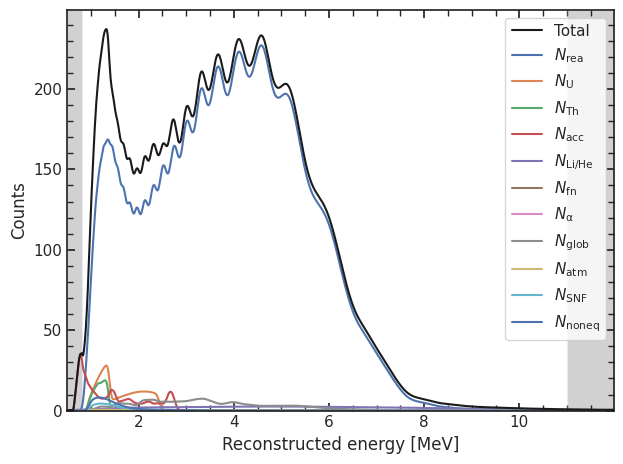

In [2]:
model = orsa.model.read_json('0_test_model.json')
model.exposure = 6*365.25
model

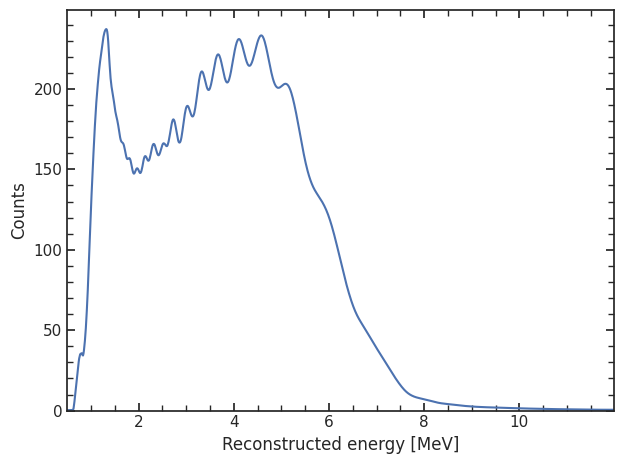

In [3]:
data = model.get_spectrum(asimov = True)
data

In [4]:
for param in model.detector_parameters:
    model.detector_parameters[param].fixed = True

for param in model.core_parameters:
    model.core_parameters[param].fixed = True

for param in model.normalization_parameters:
    if model.normalization_parameters[param].label != 'rea':
        model.normalization_parameters[param].fixed = True

model.parameters['rho'].fixed = True

In [6]:
init_model = model.copy()
min_func_bin = orsa.probability.CostFunction(ll=orsa.probability.chi2, ll_args=dict(data=data), lp_args=model.get_priors())
model.use_shape_uncertainty = False
res = orsa.fit.minuit(model, min_func_bin)

Cost function parsed as chi2-like


In [7]:
m_mcmc = orsa.fit.emcee(model, min_func_bin, 10000, err_scale=1e-3)#, backend='asimov_6y_chi2_comb_shape.h5')

Cost function parsed as chi2-like
Param. space dim.: 5
Number of walkers: 10
Number of samples: 10000
Backend h5 file: None


100%|██████████| 10000/10000 [28:15<00:00,  5.90it/s]

Discarded 5000 samples for best fit values. Recalculate them by looking at the chain.


(<Figure size 1000x1000 with 10 Axes>,
 array([[<Axes: ylabel='dm2_21'>, <Axes: >],
        [<Axes: ylabel='dm2_31'>, <Axes: >],
        [<Axes: ylabel='s2_12'>, <Axes: >],
        [<Axes: ylabel='s2_13'>, <Axes: >],
        [<Axes: xlabel='step number', ylabel='rea'>, <Axes: >]],
       dtype=object))

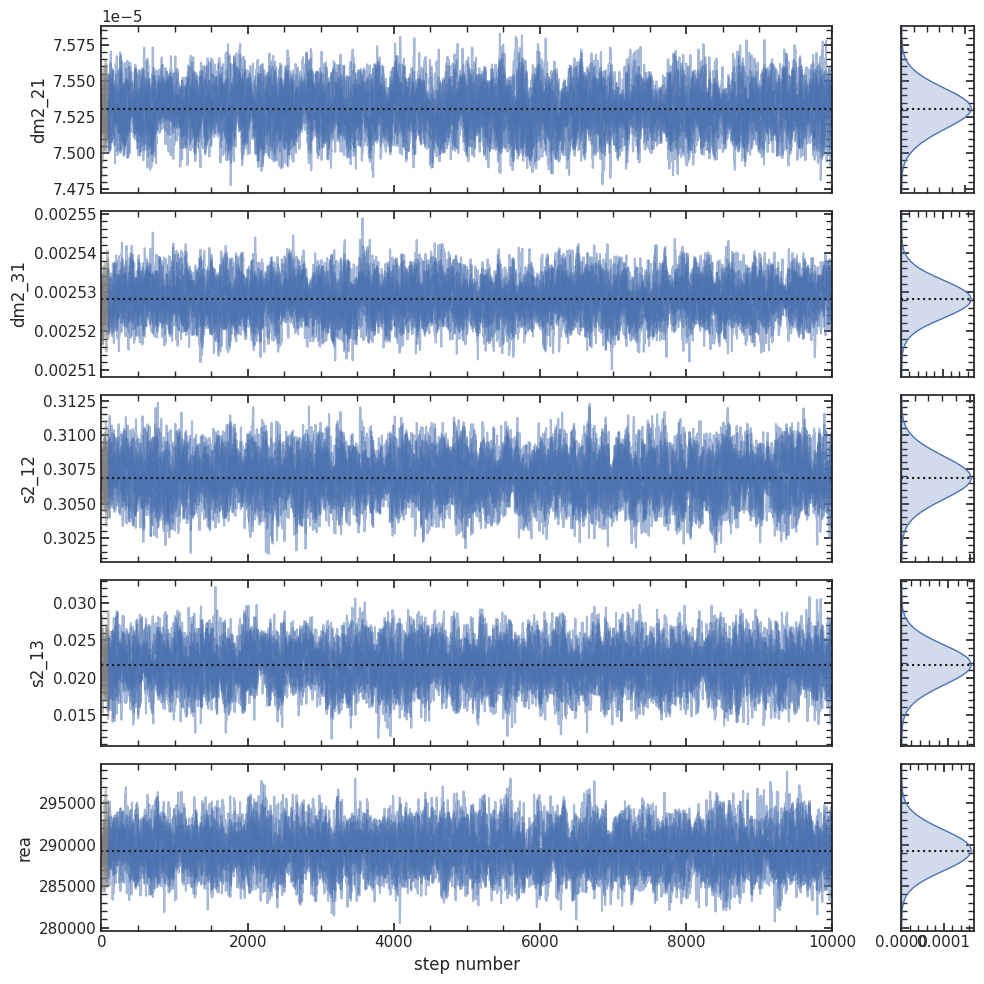

In [8]:
m_mcmc.discard = 100
orsa.plot.chain(m_mcmc)

Removed no burn in


(<Figure size 1000x1000 with 15 Axes>,
 array([[<Axes: >, None, None, None, None],
        [<Axes: ylabel='$dm2_31$'>, <Axes: >, None, None, None],
        [<Axes: ylabel='$s2_12$'>, <Axes: >, <Axes: >, None, None],
        [<Axes: ylabel='$s2_13$'>, <Axes: >, <Axes: >, <Axes: >, None],
        [<Axes: xlabel='$dm2_21$', ylabel='$rea$'>,
         <Axes: xlabel='$dm2_31$'>, <Axes: xlabel='$s2_12$'>,
         <Axes: xlabel='$s2_13$'>, <Axes: xlabel='$rea$'>]], dtype=object))

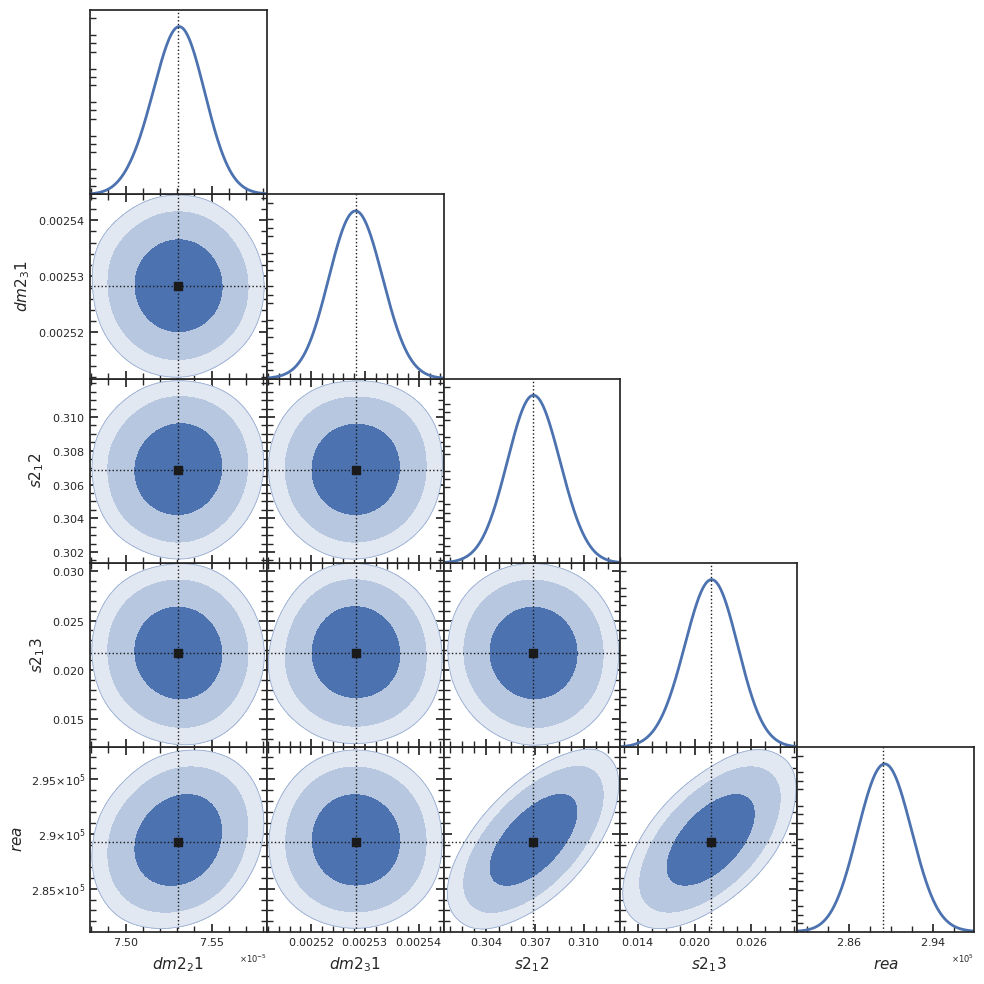

In [9]:
orsa.plot.corner(m_mcmc)

In [1]:
# from scipy.stats import norm
# fig, ax = plt.subplots(4, 8, figsize = (8*3, 4*3))
# ax = ax.flatten()
# for i, l in enumerate(labels):
#     n, edges, _ = ax[i].hist(m_mcmc.samples[:,m_mcmc.discard:,i].flatten(), histtype = 'step', bins = 20, density = True, lw = 2, label = 'MCMC')
#     x_samples = np.linspace(edges.min(), edges.max(), 1000)
#     ax[i].plot(x_samples, norm.pdf(x_samples, m_res.values[i], m_res.errors[i]), 'r-', label = 'Minuit')
#     if l in to_lab:
#         ax[i].set_xlabel(to_lab[l])
#     else:
#         ax[i].set_xlabel(l)

#     ax[i].margins(x = 0.0, y = 0.4)
#     ax[i].legend(frameon = False, loc = 'upper right')
# fig.tight_layout()
# # fig.savefig('comparison.pdf')
# # fig.savefig('comparison.png', dpi = 300)